# HI-SEAS Solar Insolation Non Linear Support Vector Regression Model

Author: Abhipray Sahoo
Date: 04//2017

### Goal: 
Estimate the solar radiation incident on the ground at HI-SEAS in order to predict power generated by solar panels. The model should be able to give best estimate for the solar radiation given meterological conditions. 

### Dataset:
A - NASA's HI-SEAS meterological data and solar irradiance. 

B - Additional climate data from Dark Sky API for the same dates as A

Uncomment cells to re-activate


## Load NASA dataset

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sns

DATA_PATH = '../hi-seas-data'

solar_radiation = pd.read_csv(os.path.join(DATA_PATH, 'solar radiation.csv'), 
                              names=["id", "unix_secs", "date", "time", "irradiance", 'txt'])
sunset = pd.read_csv(os.path.join(DATA_PATH, 'sunset.csv'), 
                              names=["id", "unix_secs", "date", "time", "sunset", 'txt'])
sunrise = pd.read_csv(os.path.join(DATA_PATH, 'sunrise.csv'), 
                              names=["id", "unix_secs", "date", "time", "sunrise", 'txt'])
temperature = pd.read_csv(os.path.join(DATA_PATH, 'temperature.csv'), 
                              names=["id", "unix_secs", "date", "time", "temperature", 'txt'])
humidity = pd.read_csv(os.path.join(DATA_PATH, 'humidity.csv'), 
                              names=["id", "unix_secs", "date", "time", "humidity", 'txt'])
wind_dir = pd.read_csv(os.path.join(DATA_PATH, 'wind direction in degrees.csv'), 
                              names=["id", "unix_secs", "date", "time", "direction", 'txt'])
wind_speed = pd.read_csv(os.path.join(DATA_PATH, 'wind speed.csv'), 
                              names=["id", "unix_secs", "date", "time", "speed", 'txt'])
barometric_pressure = pd.read_csv(os.path.join(DATA_PATH, 'wind speed.csv'), 
                              names=["id", "unix_secs", "date", "time", "pressure", 'txt'])


In [2]:
# solar_radiation.describe()

In [3]:
# sunset.describe()

In [4]:
# sunrise.describe()

In [5]:
# temperature.describe()

In [6]:
# wind_dir.describe()

In [7]:
# wind_speed.describe()

In [8]:
# Prepare data 
df = solar_radiation.join( wind_speed['speed'], on='id')
df = df.join(humidity['humidity'], on='id')
df = df.join(temperature['temperature'], on='id')
# df = df.merge(sunrise[['sunrise', 'date']], on='date', how='left')
# df = df.merge(sunset[['sunset', 'date']], on='date', how='left')
df = df.join(wind_dir['direction'], on='id')
df = df.join(barometric_pressure['pressure'], on='id')
df = df.drop('txt', 1)

# Get only features
X_feat = df[['irradiance', 'speed', 'humidity', 'temperature', 'direction', 'pressure']]

In [9]:
# Save all date times so we can augment the dataset from another source
df[['date', 'time']].to_csv('date_times.csv')

In [10]:
# WHAT??? THERE ARE NANs?? 
sset = set(solar_radiation['date'])
srise = set(sunrise['date'])
print(srise - sset)
print(sset - srise)
## OH WOOPS DATES MISSING!

{'2016-12-07', '2016-12-06'}
{'2016-11-30'}


In [11]:
# Drop any nans 
X_feat = X_feat.dropna()
X_feat.describe()

,irradiance,speed,humidity,temperature,direction,pressure
count,33132.000000,33132.000000,33132.000000,33132.000000,33132.000000,33132.000000
mean,207.948910,6.260121,75.022969,51.088434,143.195941,6.260121
std,316.617826,3.492849,25.990133,6.200251,83.074650,3.492849
min,1.110000,0.000000,8.000000,34.000000,0.090000,0.000000
25%,1.230000,3.370000,56.000000,46.000000,81.917500,3.370000
50%,2.670000,5.620000,85.000000,50.000000,147.370000,5.620000
75%,355.800000,7.870000,97.000000,55.000000,179.125000,7.870000
max,1601.260000,40.500000,103.000000,71.000000,359.950000,40.500000


## Check correlations

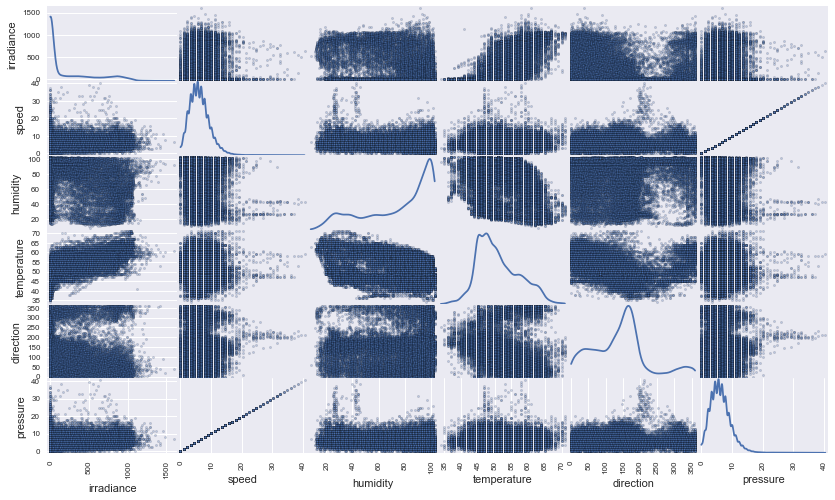

In [12]:
pd.scatter_matrix(X_feat, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [13]:
# Speed and pressure are strongly correlated, let's drop one of those columns. 
X_feat_clean = X_feat.drop('speed', 1)

# Observation: Temperature is kinda correlated with irradiance

In [14]:
# Quick test: can we do simple linear SV regression? 
import sklearn

y = np.array(X_feat_clean['irradiance'])
X = np.array(X_feat_clean.drop('irradiance', 1))

In [15]:
from sklearn.svm import LinearSVR

svm = LinearSVR()
svm.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [16]:
r2_score = svm.score(X, y)
print(r2_score)

0.405792594327


## Augment NASA's data with more features

In [17]:
# load the json 
forecast = pd.read_json('../forecast_data_HISEAS.json')

# The data is hourly updates for every date

In [18]:
aug = forecast.loc['hourly']

In [19]:
# Get rid of the "time" in the "datetime"
aug = aug.rename(lambda x : x.strftime('%Y-%m-%d'))

In [20]:
# Align NASA's data with the forecast API's
import time
X_aug = []
X_nasa = np.array(df)
c = 0
for row in df.iterrows():
    date = row[1]['date']
#     print(date)
    ti = row[1]['time']
    # Find corresponding date in aug
    data = aug.loc[date]['data']
    # Find which hour, time corresponds to
    hour = time.strptime(ti, '%H:%M:%S').tm_hour
    hour_data = data[hour]
    new_row = pd.Series(hour_data)
    new_row = new_row[['humidity', 'windSpeed', 'windBearing', 'precipIntensity', 
                       'precipProbability', 'pressure', 'visibility', 'cloudCover']]
    new_row = new_row.rename(lambda x: x+'_fc')
    to_append = pd.concat([row[1], new_row]).to_frame()
    if to_append.shape[0] == 18:
        X_aug.append(to_append)  
    else:
        print(time)
        print(row, row[1].shape)
        print(new_row, new_row.shape)
        break
#     c +=1
#     if c > 5:
#         break
        
print(len(X_aug))
X_aug = pd.concat(X_aug, axis=1).transpose()     
X_aug.describe()

33133


,id,unix_secs,date,time,irradiance,speed,humidity,temperature,direction,pressure,humidity_fc,windSpeed_fc,windBearing_fc,precipIntensity_fc,precipProbability_fc,pressure_fc,visibility_fc,cloudCover_fc
count,33133,33133,33133,33133,33133.00,33132.00,33132.0,33132.0,33132.00,33132.00,33133.00,33133.0,33133,33133.0,33133.0,33133.0,33133.0,32008.00
unique,33133,33133,120,8324,14625.00,37.00,94.0,38.0,18056.00,37.00,68.00,855.0,356,186.0,70.0,791.0,221.0,67.00
top,33133,1478754303,2016-10-19,16:20:18,1.22,5.62,102.0,45.0,0.11,5.62,0.82,2.6,153,0.0,0.0,1015.5,10.0,0.31
freq,1,1,288,24,2284.00,4694.00,2131.0,2982.0,94.00,4694.00,1210.00,161.0,345,23488.0,23488.0,178.0,23094.0,6648.00


In [21]:
# Convert things to SI units
X_aug['pressure'] = X_aug['pressure'] * 133.33  # Hg to Pa 
X_aug['humidity'] = X_aug['humidity'] / 100.0  # Percent to ratio

In [22]:
rel_cols = X_aug.drop(['id', 'unix_secs', 'date', 'time', 'speed', 'windSpeed_fc', 'humidity_fc', 'windBearing_fc', 'pressure_fc'], 1).astype(float)
rel_cols.describe()

,irradiance,humidity,temperature,direction,pressure,precipIntensity_fc,precipProbability_fc,visibility_fc,cloudCover_fc
count,33133.000000,33132.000000,33132.000000,33132.000000,33132.000000,33133.000000,33133.000000,33133.000000,32008.000000
mean,207.942670,0.750230,51.088434,143.195941,834.661937,0.005715,0.112049,9.581816,0.174349
std,316.615085,0.259901,6.200251,83.074650,465.701608,0.019662,0.224908,0.966955,0.154880
min,1.110000,0.080000,34.000000,0.090000,0.000000,0.000000,0.000000,2.550000,0.000000
25%,1.230000,0.560000,46.000000,81.917500,449.322100,0.000000,0.000000,9.750000,0.050000
50%,2.670000,0.850000,50.000000,147.370000,749.314600,0.000000,0.000000,10.000000,0.140000
75%,355.770000,0.970000,55.000000,179.125000,1049.307100,0.002200,0.060000,10.000000,0.310000
max,1601.260000,1.030000,71.000000,359.950000,5399.865000,0.335500,0.890000,10.000000,1.000000


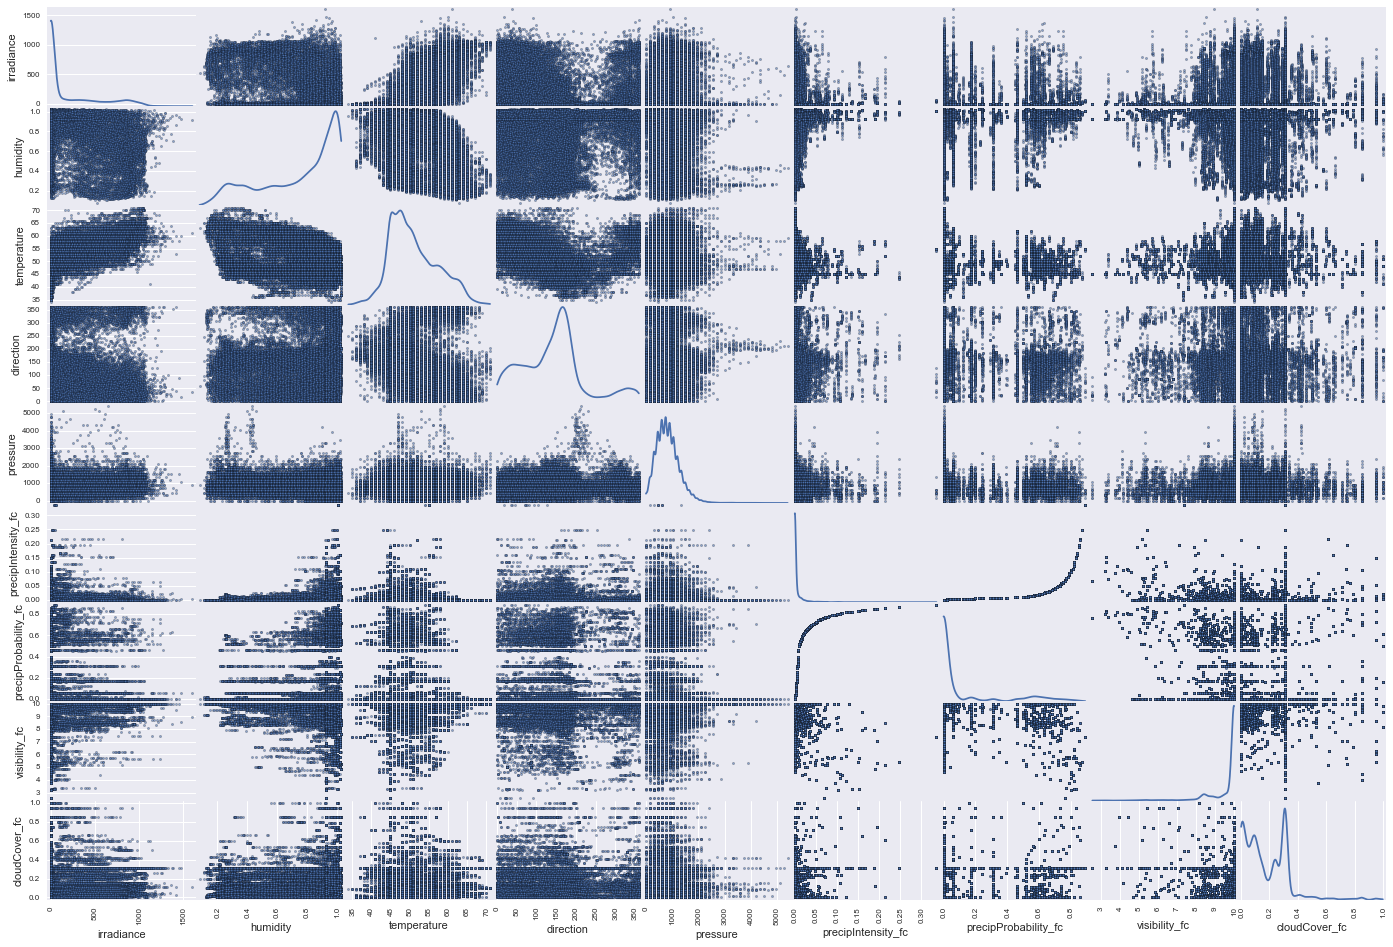

In [23]:
pd.scatter_matrix(rel_cols, alpha = 0.6, figsize = (24,16), diagonal = 'kde');

In [48]:
# Do log transform to remove skewness
# from scipy.stats import boxcox
# b = np.log(1e-20 + rel_cols)
# pd.scatter_matrix(b, alpha = 1.0, figsize = (24,16), diagonal = 'kde');

In [47]:
# def correlation_matrix(df):
#     from matplotlib import pyplot as plt
#     from matplotlib import cm as cm

#     fig = plt.figure(figsize = (24,16))
#     ax1 = fig.add_subplot(111)
#     cmap = cm.get_cmap('jet', 30)
#     cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
#     ax1.grid(True)
#     plt.title('Feature Correlation')
#     labels= df.columns.values
#     ax1.set_xticks(np.arange(len(labels)))
#     ax1.set_xticklabels(labels,fontsize=10)
#     ax1.set_yticks(np.arange(len(labels)))
#     ax1.set_yticklabels(labels,fontsize=10)
#     # Add colorbar, make sure to specify tick locations to match desired ticklabels
#     fig.colorbar(cax, ticks=np.linspace(-1, 1)) #[.6, .65, .7, .75,.8,.85,.90,.95, 1])
#     plt.show()

# correlation_matrix(b)

Confusion matrix, without normalization


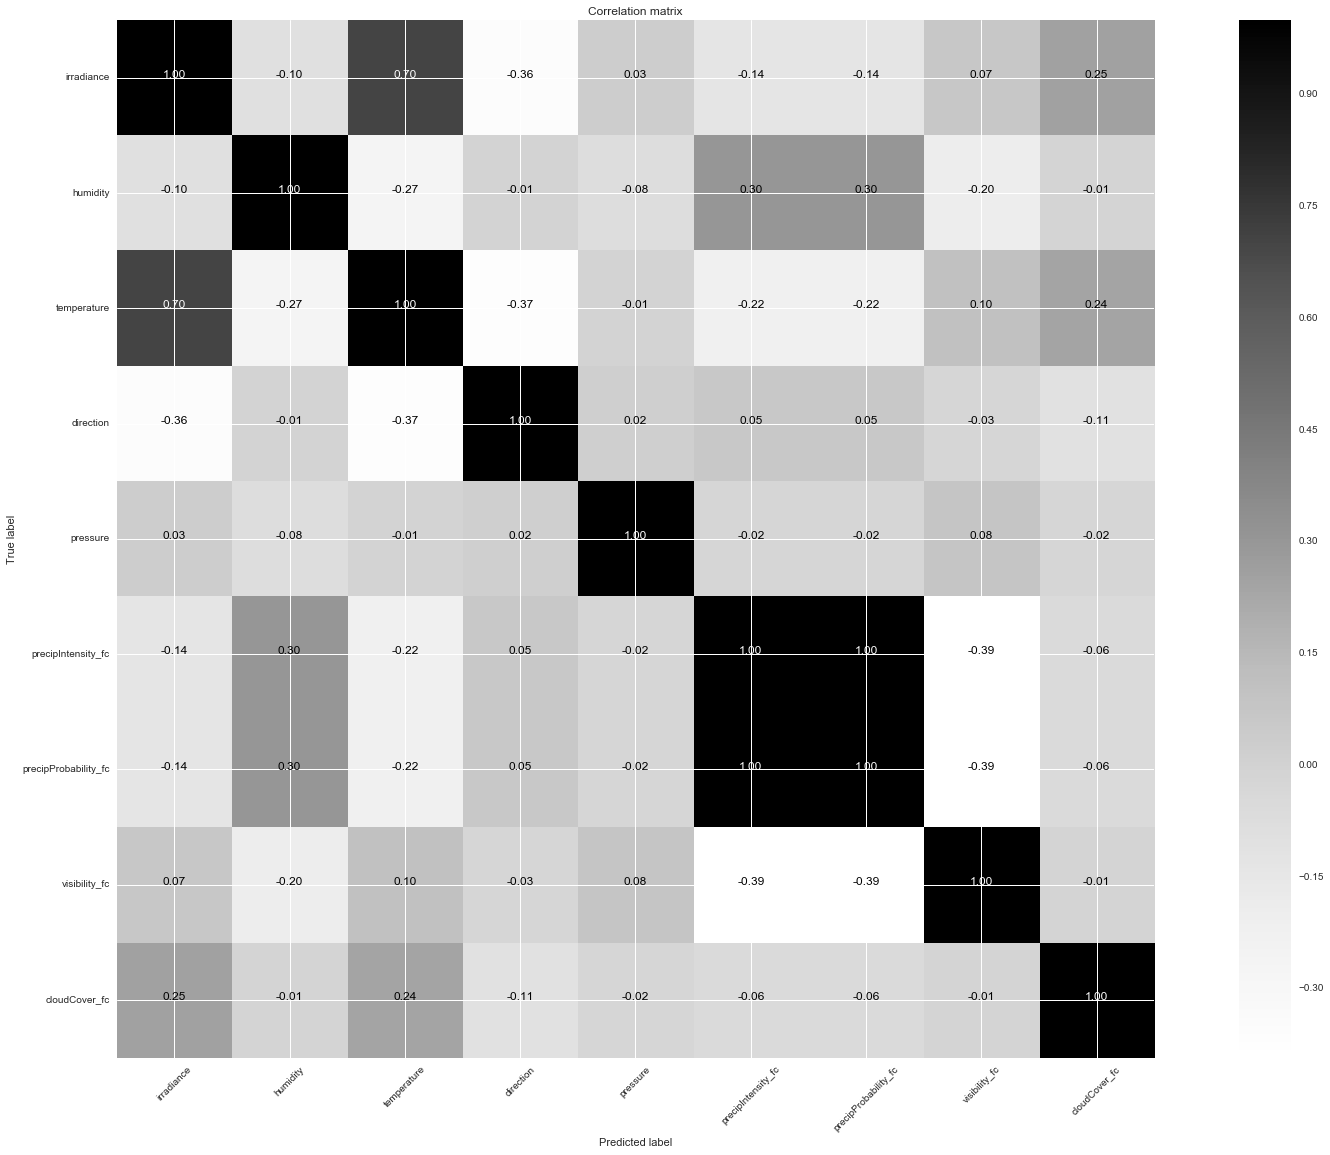

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize_data=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize_data=True`.
    """
    import matplotlib.pyplot as plt
    import itertools
    np.set_printoptions(precision=2)
    plt.figure(figsize= (24, 16))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize_data:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(np.asscalar(cm[i, j])),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(np.array(b.corr()), rel_cols.columns.values,
                      normalize_data=False,
                      title='Correlation matrix')

## Learn Linear Regression with only correlated features

1. Per feature scaling between min max
2. PCA on training data to increase variance
3. Train a linear regression model

In [67]:
# Observation: Cloud coverage doesn't seem to correlate much? Apparently Hawaii is cloudy 
# for large parts of the year. Also depends a lot on cloud type? Some clouds reflect a lot of the
# light and performance actually increases. 
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

tmp = b.dropna()
print(tmp.shape)
y = np.array(tmp['irradiance'])
X = np.array(tmp[['temperature', 'direction', 'cloudCover_fc']])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

# Perform PCA on training data
pca = PCA()
X_pca = pca.fit_transform(X_train)

linreg = LinearRegression()
linreg.fit(X_pca, y_train)

(32007, 9)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [68]:
X_test_pca = pca.transform(X_test)
r2 = linreg.score(X_test_pca, y_test)
y_pred = linreg.predict(X_test_pca)
mse = mean_squared_error(y_pred, y_test)

print('Mean Squared Error: {}\nR2 coefficient: {}'.format(mse, r2))

Mean Squared Error: 3.6805414102781926
R2 coefficient: 0.5145547142341238


In [42]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import PipelineD

scaler = StandardScaler()
X_train = scaler.fit_transform(X)


model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X.shape[1], )))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.fit(X_train, y, validation_split=0.1, shuffle=True, batch_size=32, epochs=60)

Train on 28806 samples, validate on 3201 samples
Epoch 1/60
28806/28806 [==============================] - 2s - loss: 3.5093 - mean_squared_error: 3.5093 - val_loss: 4.8621 - val_mean_squared_error: 4.8621
Epoch 2/60
28806/28806 [==============================] - 2s - loss: 2.9146 - mean_squared_error: 2.9146 - val_loss: 4.8339 - val_mean_squared_error: 4.8339
Epoch 3/60
28806/28806 [==============================] - 2s - loss: 2.7805 - mean_squared_error: 2.7805 - val_loss: 4.2898 - val_mean_squared_error: 4.2898
Epoch 4/60
28806/28806 [==============================] - 2s - loss: 2.7087 - mean_squared_error: 2.7087 - val_loss: 4.4494 - val_mean_squared_error: 4.4494
Epoch 5/60
28806/28806 [==============================] - 2s - loss: 2.6758 - mean_squared_error: 2.6758 - val_loss: 4.1407 - val_mean_squared_error: 4.1407
Epoch 6/60
28806/28806 [==============================] - 2s - loss: 2.6532 - mean_squared_error: 2.6532 - val_loss: 3.8249 - val_mean_squared_error: 3.8249
Epoch 7/6

In [43]:
model.evaluate(X_train, y)

31584/32007 [============================>.] - ETA: 0s

[2.5330733308598217, 2.5330733308598217]

In [44]:
model.predict(X_train[0][None,:])

array([[ 1.35]], dtype=float32)

In [45]:
y[0]

0.23901690047049992